# **Geospatial Data Visualisation**

*Over the summer months, I had a part-time job as a Courier at **UberEats**. The idea to do this came suddenly, even though I’ve always loved biking and being outside. The weather was mostly sunny (or at least dry), and the bike lanes are well developed – I am in the Netherlands, after all.*

*During delivering, I had plenty time to think. While paying attention to the traffic and the work, of course. I was thinking about the system behind delivery application. How often or when exactly do I get a new order? In what cases do I get double or sometimes triple orders? In short, **how does their algorithm work**? I wanted to understand it and make observations. How does the time of the day, the day of the week, the current weather or local events influence the number of orders to deliver? Are these related to the distance between the restaurant and the customer? Or take the bonus system, for another example. In a given time interval of a day, and after a certain number of orders delivered, one gets some bonuses. My first thought was, **how can I optimise this system**? When should I take my shifts to maximise the expected earnings? I think that these show very well how my brain is wired – analytical and curious, constantly thinking of real-world algorithms and strategies.*

*As a final step for my summer Courier career, I wanted to visualise my performance. I could have plotted the number of daily completed orders, but I wanted more than a bar chart. Or I could have presented the customer reviews, but for that, there was not enough data. Fortunately, I measured every delivery shift of mine, as a workout (indeed they were a workout) with geolocational data. Now, **I have quite a lot of tracks to visualise**.*

## **Extracting the Data**

Firstly, we need to extract the relevant geospatial data. I personally measured my routes using my Apple Watch, which provides GPS data in a format that we can work with. The data includes information such as the route taken, distance, and elevation changes. To extract the data from Apple's Health app, open the app and navigate to your picture or initials at the top right corner. Tap Export All Health Data, then choose a method for sharing your data. Source: [Share your health and fitness data in XML format](https://support.apple.com/en-gb/guide/iphone/iph5ede58c3d/ios). After some preparation, which can take a while depending on the amount of data, you should have a .zip file containing your health data in XML format. The folder is named "workout-routes". This folder contains the .gpx files that are basically XML files with GPS data.

One data file looks like this:
```xml
<?xml version="1.0" encoding="UTF-8"?>
<gpx version="1.1" creator="Apple Health Export" xmlns="http://www.topografix.com/GPX/1/1" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.topografix.com/GPX/1/1 http://www.topografix.com/GPX/1/1/gpx.xsd">
  <metadata>
    <time>2025-08-25T14:57:33Z</time>
  </metadata>
  <trk>
    <name>Route 2025-05-05 5:24pm</name>
    <trkseg>
      <trkpt lon="4.637620" lat="52.382577"><ele>0.357328</ele><time>2025-05-05T12:32:58Z</time><extensions><speed>0.012652</speed><course>39.776441</course><hAcc>5.546754</hAcc><vAcc>1.326746</vAcc></extensions></trkpt>
      <trkpt lon="4.637620" lat="52.382577"><ele>0.348379</ele><time>2025-05-05T12:32:59Z</time><extensions><speed>0.012272</speed><course>39.779809</course><hAcc>4.936129</hAcc><vAcc>1.181078</vAcc></extensions></trkpt>
      <trkpt lon="4.637620" lat="52.382577"><ele>0.339116</ele><time>2025-05-05T12:33:00Z</time><extensions><speed>0.011041</speed><course>39.953316</course><hAcc>4.565568</hAcc><vAcc>1.061498</vAcc></extensions></trkpt>

```

## **Quick visualisation and selection of routes**

The second step can be omitted if you already have the specific routes ready. As for me, this is not the case, because I only want to visualise the routes I took during my shift. Therefore, I will create a quick visualisation of all the routes and then select the ones I need. Most of them are in Haarlem, in the Netherlands, but I also recorded some workouts elsewhere, and I want to filter out those.

Here are some example. The first visualisation shows an average route taken in Haarlem, the second one shows a specific route I took during a weekend for leisure, and the third one shows a route taken around the Tower of London.

In [ ]:
# Imports –––––
import os


import gpxpy
import pandas as pd
from tqdm import tqdm

from scipy.spatial import cKDTree

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from scipy.spatial.distance import cdist

import numpy as np
from matplotlib.colors import LinearSegmentedColormap, to_hex
import matplotlib.font_manager as fm



## **Reading and Transforming Data**

Now, that I have only the relevant routes selected in my folder, I need to read and transform the data into a suitable format for visualisation. 

In [ ]:
'''
# Extract coordinates –––––

# Path to the folder containing GPX files
path = "/Users/milanpeter/Documents/Repositories/Geospatial-Routes-Visualisation/bike-routes"

# List all files in the folder, but keep only those ending with ".gpx"
route_names = [f for f in os.listdir(path) if f.endswith(".gpx")]

# Dictionary to store DataFrames for each route (key = filename, value = DataFrame of points)
all_routes = {}

# Loop through each GPX file, showing progress with tqdm
for r in tqdm(route_names):
    
    # Open the GPX file and parse it with gpxpy
    with open(os.path.join(path, r)) as f:
        gpx = gpxpy.parse(f)

    # Collect all points (time, latitude, longitude) for this route
    points = []
    for segment in gpx.tracks[0].segments:
        for p in segment.points:
            points.append({
                "time": p.time,
                "latitude": p.latitude,
                "longitude": p.longitude,
            })

    # Convert the list of points into a DataFrame and store it in the dictionary
    all_routes[r] = pd.DataFrame.from_records(points)

# Concatenate all route DataFrames into one combined DataFrame
coordinates = pd.concat(all_routes.values(), ignore_index=True)

# Save the combined DataFrame to a CSV file
coordinates.to_csv("coordinates_raw.csv", header=True, index=False)
'''

'\n# Extract coordinates –––––\n\n# Path to the folder containing GPX files\npath = "/Users/milanpeter/Documents/Repositories/Geospatial-Routes-Visualisation/bike-routes"\n\n# List all files in the folder, but keep only those ending with ".gpx"\nroute_names = [f for f in os.listdir(path) if f.endswith(".gpx")]\n\n# Dictionary to store DataFrames for each route (key = filename, value = DataFrame of points)\nall_routes = {}\n\n# Loop through each GPX file, showing progress with tqdm\nfor r in tqdm(route_names):\n    \n    # Open the GPX file and parse it with gpxpy\n    with open(os.path.join(path, r)) as f:\n        gpx = gpxpy.parse(f)\n\n    # Collect all points (time, latitude, longitude) for this route\n    points = []\n    for segment in gpx.tracks[0].segments:\n        for p in segment.points:\n            points.append({\n                "time": p.time,\n                "latitude": p.latitude,\n                "longitude": p.longitude,\n            })\n\n    # Convert the list of

After reading every .gpx file, only the relevant columns are kept in the DataFrame. These are the *time*, *latitude*, and *longitude* columns. This results in 68 DataFrames being created, meaning that I did 68 workouts. These DataFrames are then concatenated into a single DataFrame called *coordinates*.

coordinates has 717265 entries, i.e. 717265 GPS data points of latitude and longitude. This is a substantial amount of data, which using a lot of memory and therefore making it a bit slower to process. Fortunately, the data is well-structured and does not have any missing values.

```python
coordinates.info()
```
```
RangeIndex: 717265 entries, 0 to 717264
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  717265 non-null  int64  
 1   time        717265 non-null  object 
 2   latitude    717265 non-null  float64
 3   longitude   717265 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 21.9+ MB

```

Right now, this is how the data looks:

```python
coordinates.head(10)
```
```
   time                       latitude    longitude
0  2025-08-01 15:26:25+00:00  52.392703   4.646152
1  2025-08-01 15:26:27+00:00  52.392721   4.646159
2  2025-08-01 15:26:28+00:00  52.392737   4.646165
3  2025-08-01 15:26:30+00:00  52.392758   4.646168
4  2025-08-01 15:26:31+00:00  52.392766   4.646169
5  2025-08-01 15:26:32+00:00  52.392772   4.646168
6  2025-08-01 15:26:33+00:00  52.392775   4.646167
7  2025-08-01 15:26:34+00:00  52.392778   4.646166
8  2025-08-01 15:26:35+00:00  52.392781   4.646165
9  2025-08-01 15:26:36+00:00  52.392783   4.646163
```

As the next step, I will remove the time column. For the visualization, I only need the latitude and longitude columns. If you want to make an animated plot, you should keep the time column as well, but I have something else in mind. I do not want to animate the plot over time, but rather over a specific route from a specific starting point.

As for handling the large number of data points, I will use several techniques to reduce it and aggregate it. First, I will round the latitude and longitude values to a certain number of decimal places. Then, I create a column *occurrence* that counts the number of times each latitude and longitude pair appears in the DataFrame. All coordinates are decimal numbers with 6 decimal places. Counting the occurrences of each pair without rounding would result in an identical plot, as the coordinates would be the same. Rounding to 5 decimal places means that the coordinates are accurate to about 1.1 meters, which would be sufficient for my purposes. Rounding to 4 decimal places would result in an accuracy of about 11 meters, which is too coarse, and I would like to see smooth lines. And rounding to 3 decimal places would result in an accuracy of about 110 meters, which is definitely too scattered. Rounding to 5 decimal places would be a good compromise between accuracy and data reduction, but there are too many unique pairs of coordinates, resulting in almost 400,000 entries. This is still quite large and would make the visualization slow. That is why I scaled the numbers so the 5th decimal became an integer, rounded that integer to the nearest multiple of 5, and then scaled back down. This way, the 5th decimal digit always ends up as 0 or 5.

In [133]:
# Preprocess coordinates –––––

# Read the CSV file
coordinates = pd.read_csv("coordinates_raw.csv")

# Drop the column "time" since it's not needed
coordinates = coordinates.drop(columns="time")

# Round all columns to 5 decimal places, with the digits always end up as 0 or 5
factor = 10**5
coordinates["longitude"] = np.round(coordinates["longitude"] * factor / 5) * 5 / factor
coordinates["latitude"] = np.round(coordinates["latitude"] * factor / 5) * 5 / factor

# Group by unique latitude–longitude pairs, count how many times each pair occurs
coordinates = coordinates.groupby(["latitude", "longitude"]).size().reset_index(name="occurrence")

After rounding and aggregating, this is how the data looks:

```python
coordinates.sort_values(by="occurrence", ascending=False).head(10)
```
```
   latitude    longitude       occurrence
0  52.37937    4.63258         704
1  52.37931    4.63339         538
2  52.37930    4.63339         401
3  52.37930    4.63338         400
4  52.37930    4.63340         348
5  52.37932    4.63339         338
6  52.36485    4.64489         337
7  52.38363    4.64178         335
8  52.38677    4.63664         329
9  52.37931    4.63340         324
```

I would like the routes to be a distinct colour. First, I thought of using the official UberEats green colour. However, I wanted to show a gradient of colours, from light green to dark green, to represent the frequency of visits to each location. After some experimentation, I found that it would not be possible, becuase my data is heavily skewed. There are a few locations that I visited very frequently, while most locations were visited only a few times. Therefore, I decided to start the gradient from my starting location, which is the location with the highest occurrence, in the heart of Haarlem (which is a McDonald's). I tried several colour maps consisting of different shades of green, then I settled on the one I liked the most.

I used the Euclidean distance formula $(1)$ for calculating the distance from the starting point for each coordinate pair. This distance is in the column *eucledian_distance*, which is then normalised to a range between 0 and 1, in the column *normalised_distance*. This is then used to map the distances to colours in the chosen colour map. The resulting colours are stored in a new column called *gradient_colour*.

$$
\text{eucledian\_distance} = \sqrt{(\text{latitude} - \text{starting\_latitude})^2 + (\text{longitude} - \text{starting\_longitude})^2} \tag{1}
$$

In [134]:
# Colour generation by distance –––––

# Define starting point
start_point = {}
start_point["latitude"] = coordinates.loc[coordinates["occurrence"].argmax(), "latitude"]
start_point["longitude"] = coordinates.loc[coordinates["occurrence"].argmax(), "longitude"]

# Calculate Eucledian distance
coordinates["eucledian_distance"] = np.sqrt((coordinates["latitude"] - start_point["latitude"])**2 + (coordinates["longitude"] - start_point["longitude"])**2)

# Normalise distances to [0,1]
coordinates["normalised_distance"] = (coordinates["eucledian_distance"] - coordinates["eucledian_distance"].min()) / (coordinates["eucledian_distance"].max() - coordinates["eucledian_distance"].min())

# Custom colormap
cmap = LinearSegmentedColormap.from_list("custom_gradient", [(0.0, "#008552"),
                                                             (0.7, "#9ebd13"),
                                                             (1.0, "#9ebd13")])

# Map normalised distance to hex colours
coordinates["gradient_colour"] = [to_hex(cmap(v)) for v in coordinates["normalised_distance"]]

# Possible colours
# "#5FB707"
# (0.0, "#008552"), (0.7, "#9ebd13"), (1.0, "#9ebd13")
# (0.0, "#2A7B9B"), (0.5, "#57C785"), (1.0, "#EDDD53")

## **Visualisation**

First, I create a static plot using Matplotlib. I set up the figure and axes, then plotted the coordinates using a scatter plot. The colours of the points were determined by the *gradient_colour* column. The background of the plot is set to a basemap of Haarlem, which I obtained from OpenStreetMap using the `contextily` library. Its style is "Positron", which is a clean and minimalistic look. Finally, I set the title and additional information, such as delivered orders and total distance cycled. For the text, I used the "Futura" font, which is similar to the font used in the UberEats app.

In [ ]:
# Import fonts –––––
futura_book = fm.FontProperties(fname="/Users/milanpeter/Library/Fonts/FuturaLT-Book.ttf")
futura_heavy = fm.FontProperties(fname="/Users/milanpeter/Library/Fonts/FuturaLT-Heavy.ttf")
futura_extrabold = fm.FontProperties(fname="/Users/milanpeter/Library/Fonts/FuturaLT-ExtraBold.ttf")
futura_bold = fm.FontProperties(fname="/Users/milanpeter/Library/Fonts/FuturaLT-Bold.ttf")

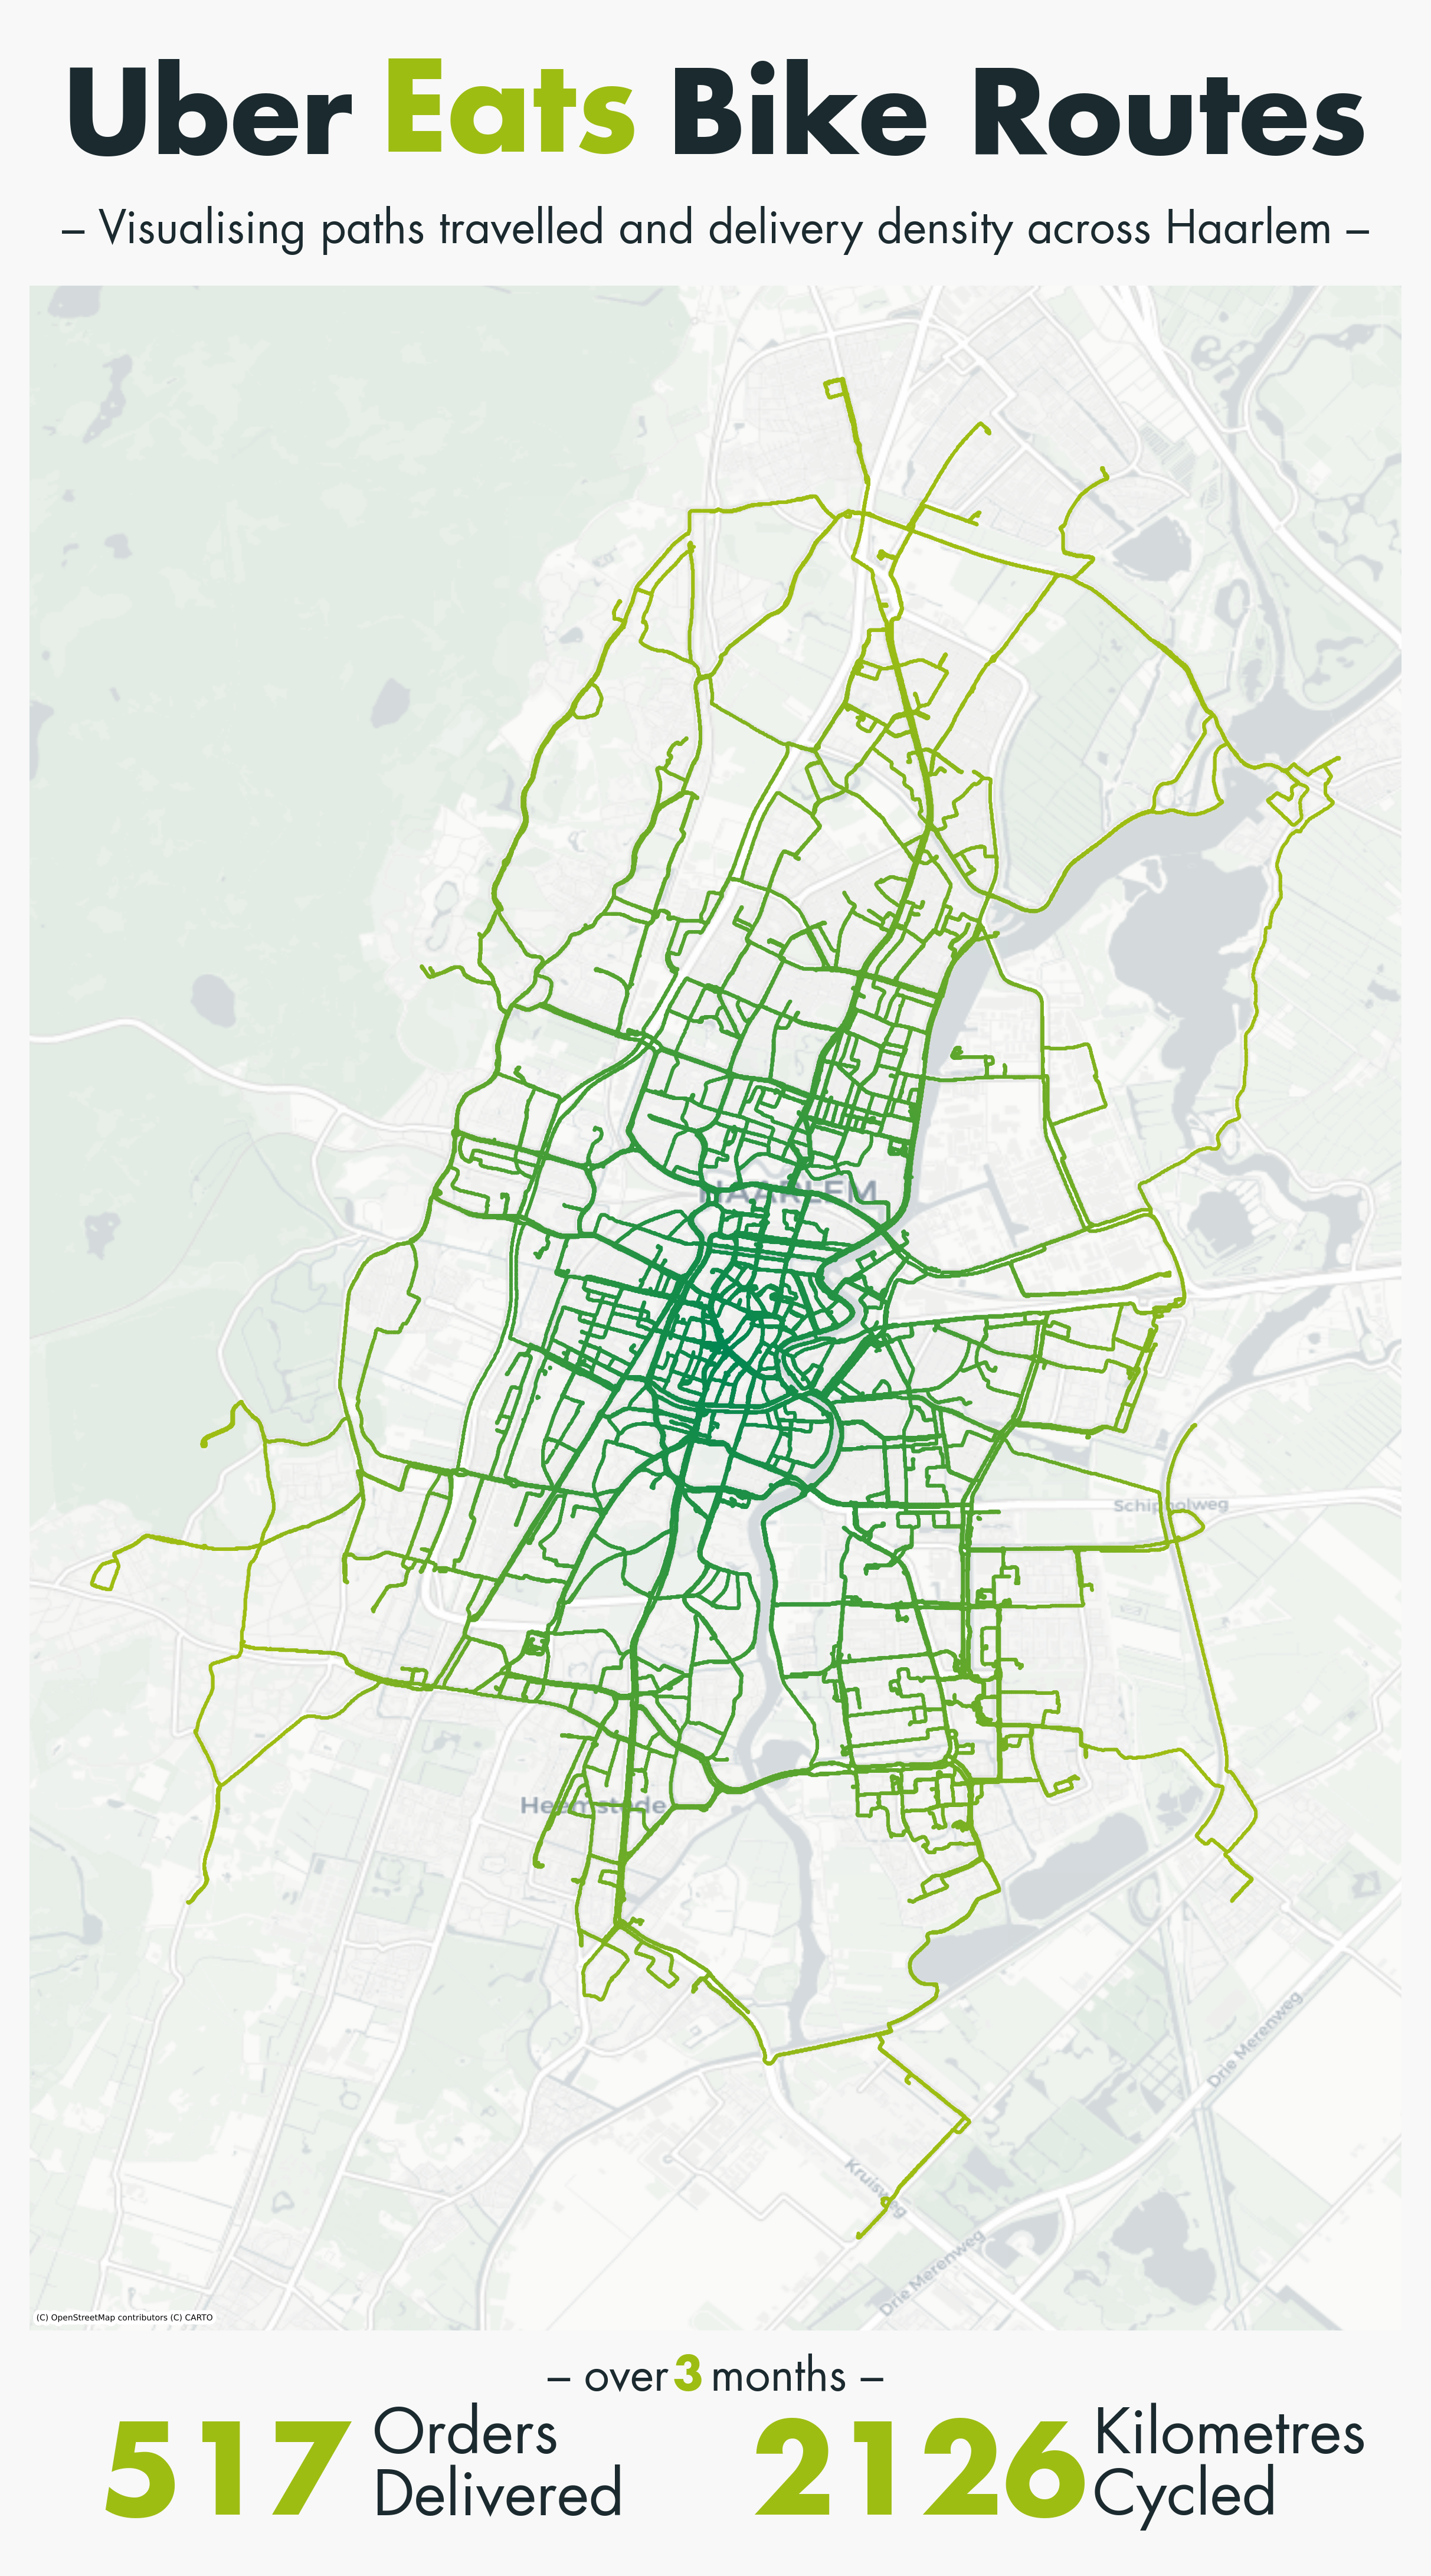

In [147]:
# Static map visualisation –––––

# Outside of the loop –

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 9), dpi=500)

# Set the background color to white
fig.patch.set_facecolor("#F8F8F8")

# Remove default axis visuals
ax.set_axis_off()

# Title
# Spacing
ax.text(0.5, 1.11, "  ", transform=ax.transAxes)

# Title text
ax.text(0.5, 1.05, "Uber        Bike Routes", transform=ax.transAxes, ha="center", va="bottom",
        fontsize=28, color="#1B2A2F", fontproperties=futura_bold)
ax.text(0.35, 1.05, "Eats", transform=ax.transAxes, ha="center", va="bottom",
        fontsize=30, color="#9ebd13", fontproperties=futura_bold)
ax.text(0.5, 1.015, "– Visualising paths travelled and delivery density across Haarlem –",
        transform=ax.transAxes, ha="center", va="bottom",
        fontsize=11, color="#1B2A2F", fontproperties=futura_book)

# Summary text under the map
ax.text(0.5, -0.035, "– over   months –",
        transform=ax.transAxes, ha="center", va="bottom",
        fontsize=11, color="#1B2A2F", fontproperties=futura_book)
ax.text(0.48, -0.035, "3",
        transform=ax.transAxes, ha="center", va="bottom",
        fontsize=11, color="#9ebd13", fontproperties=futura_bold)

# Orders delivered
ax.text(0.05, -0.09, "517", transform=ax.transAxes, ha="left",
        fontsize=30, color="#9ebd13", fontproperties=futura_bold)
ax.text(0.25, -0.06, "Orders", transform=ax.transAxes, ha="left",
        fontsize=15, color="#1B2A2F", fontproperties=futura_book)
ax.text(0.25, -0.09, "Delivered", transform=ax.transAxes, ha="left",
        fontsize=15, color="#1B2A2F", fontproperties=futura_book)

# Kilometres cycled
ax.text(0.525, -0.09, "2126",
        transform=ax.transAxes, ha="left",
        fontsize=30, color="#9ebd13", fontproperties=futura_bold)
ax.text(0.775, -0.06, "Kilometres", transform=ax.transAxes, ha="left",
        fontsize=15, color="#1B2A2F", fontproperties=futura_book)
ax.text(0.775, -0.09, "Cycled", transform=ax.transAxes, ha="left",
        fontsize=15, color="#1B2A2F", fontproperties=futura_book)

# Spacing
ax.text(0.5, -0.09, "  ", transform=ax.transAxes)


# Inside the loop –

# Create GeoDataFrames
gdf_route = gpd.GeoDataFrame(
    coordinates,
    geometry=gpd.points_from_xy(coordinates["longitude"], coordinates["latitude"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# Path points
ax.scatter(
    x=gdf_route.geometry.x,
    y=gdf_route.geometry.y,
    s=3,
    c=list(coordinates["gradient_colour"]),
    marker='.',
    linewidths=0
)

# Add basemap
ctx.add_basemap(ax=ax,
                source=ctx.providers.CartoDB.Positron,
                crs=gdf_route.crs.to_string(),
                attribution_size=2)

plt.savefig("github-pictures/final-map.jpg", dpi=500, bbox_inches="tight")
plt.show(fig)

I start with the animation of the map itself. Let it zoom out from the starting location to the full view of the route. I don't want to start with a too zoomed-in map, as it would not be very interesting. I want to show the old town of Haarlem, with its unique outline of streets and canals, then zoom out to show the full route.

In [149]:
# Define number of frames –––––
# I want the animation to be smooth, so I define a high number of frames
frame_number = 1000

In [150]:
# Creating artificial frames –––––

# Get bounds of your real data
lat_min, lat_max = coordinates["latitude"].min(), coordinates["latitude"].max()
lon_min, lon_max = coordinates["longitude"].min(), coordinates["longitude"].max()

# Define number of artificial points along each axis
n_lat, n_lon = 1000, 1000  # adjust as needed

lat_grid = np.linspace(lat_min, lat_max, n_lat)
lon_grid = np.linspace(lon_min, lon_max, n_lon)

# Create a meshgrid (cross/lattice)
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)
artificial_points = np.column_stack([lat_mesh.ravel(), lon_mesh.ravel()])

# Select artificial points where latitude equals start_point["latitude"] or longitude equals start_point["longitude"]
artificial_points = artificial_points[
    (np.isclose(artificial_points[:, 0], start_point["latitude"])) |
    (np.isclose(artificial_points[:, 1], start_point["longitude"]))
]


start_coords = np.array([[start_point["latitude"], start_point["longitude"]]])
distances = cdist(artificial_points, start_coords).ravel()

# Assign frame numbers based on relative distance
artificial_frames = np.interp(distances, (distances.min(), distances.max()), (1, frame_number)).round(0)

Now the path animation part.

I want the animation (which means that the coordinates appearing one by one) to start from the starting location. To achieve this, I have two methods in mind.

The first method is to sort the data by the Euclidean distance from the starting point, in ascending order. This way, the points closest to the starting point will be plotted first, and the points furthest away will be plotted last. You can see this in the first gif below, but it is not exactly what I want. The points are plotted in a circular manner, which does not represent the actual route taken.

The second method is to use a custom sorting algorithm that takes into account not only the distance from the starting point but also the direction of movement. This way, the points will be plotted in a more natural order, following the actual route taken.

In [151]:
# Creating natural frames –––––

# Frames by distance
coordinates = coordinates.sort_values(by="eucledian_distance")

coordinates["frame_by_distance"] = np.linspace(1, frame_number, len(coordinates)).round(0)


# Frames by path

# Convert coordinates to numpy array
points = coordinates[["latitude", "longitude"]].to_numpy()
tree = cKDTree(points)

visited = np.zeros(len(points), dtype=bool)
frame_by_path = np.zeros(len(points))

# Start with the initial point
start_coords = np.array([start_point["latitude"], start_point["longitude"]])
start_idx = np.argmin(np.sum((points - start_coords) ** 2, axis=1))

front = [start_idx]
visited[start_idx] = True
frame_counter = 1

while front:
    next_front = []
    for idx in front:
        # Mark frame number
        frame_by_path[idx] = frame_counter
        
        # Query nearest neighbors (you can adjust k)
        dist, neighbors = tree.query(points[idx], k=10)
        if np.isscalar(neighbors):
            neighbors = [neighbors]
        for n_idx in neighbors:
            if not visited[n_idx]:
                visited[n_idx] = True
                next_front.append(n_idx)
    front = next_front
    frame_counter += 1


coordinates["frame_by_path"] = np.interp(frame_by_path, (frame_by_path.min(), frame_by_path.max()), (1, frame_number)).round(0)

# Remove outlier frames
mask_outliers = (coordinates["frame_by_path"] == 1) & (coordinates["frame_by_distance"] > 1)
coordinates.loc[mask_outliers, "frame_by_path"] = np.nan

## **Final Animation**

After defining the animation of the map and the path, I combine them into a single animation. This involves rendering each frame of the map animation first, followed by the corresponding frame of the path animation. The result is a smooth transition from the zoomed-in view of the starting location to the full view of the route, with the path being drawn in real-time. There are many data points, so the animation is quite long, but it effectively showcases the entire route. It takes a while to render, but the final result is worth it.

When all frames are rendered, I use another tool to combine them into a single video file. This involves stitching together the individual frames into a continuous video format, such as MP4 or GIF. The final video can then be shared or uploaded to various platforms for viewing.

Frame 24 created
Frame 25 created
Frame 26 created
Frame 27 created
Frame 28 created
Frame 29 created
Frame 30 created
Frame 31 created
Frame 32 created
Frame 33 created
Frame 34 created
Frame 35 created
Frame 36 created
Frame 37 created


KeyboardInterrupt: 

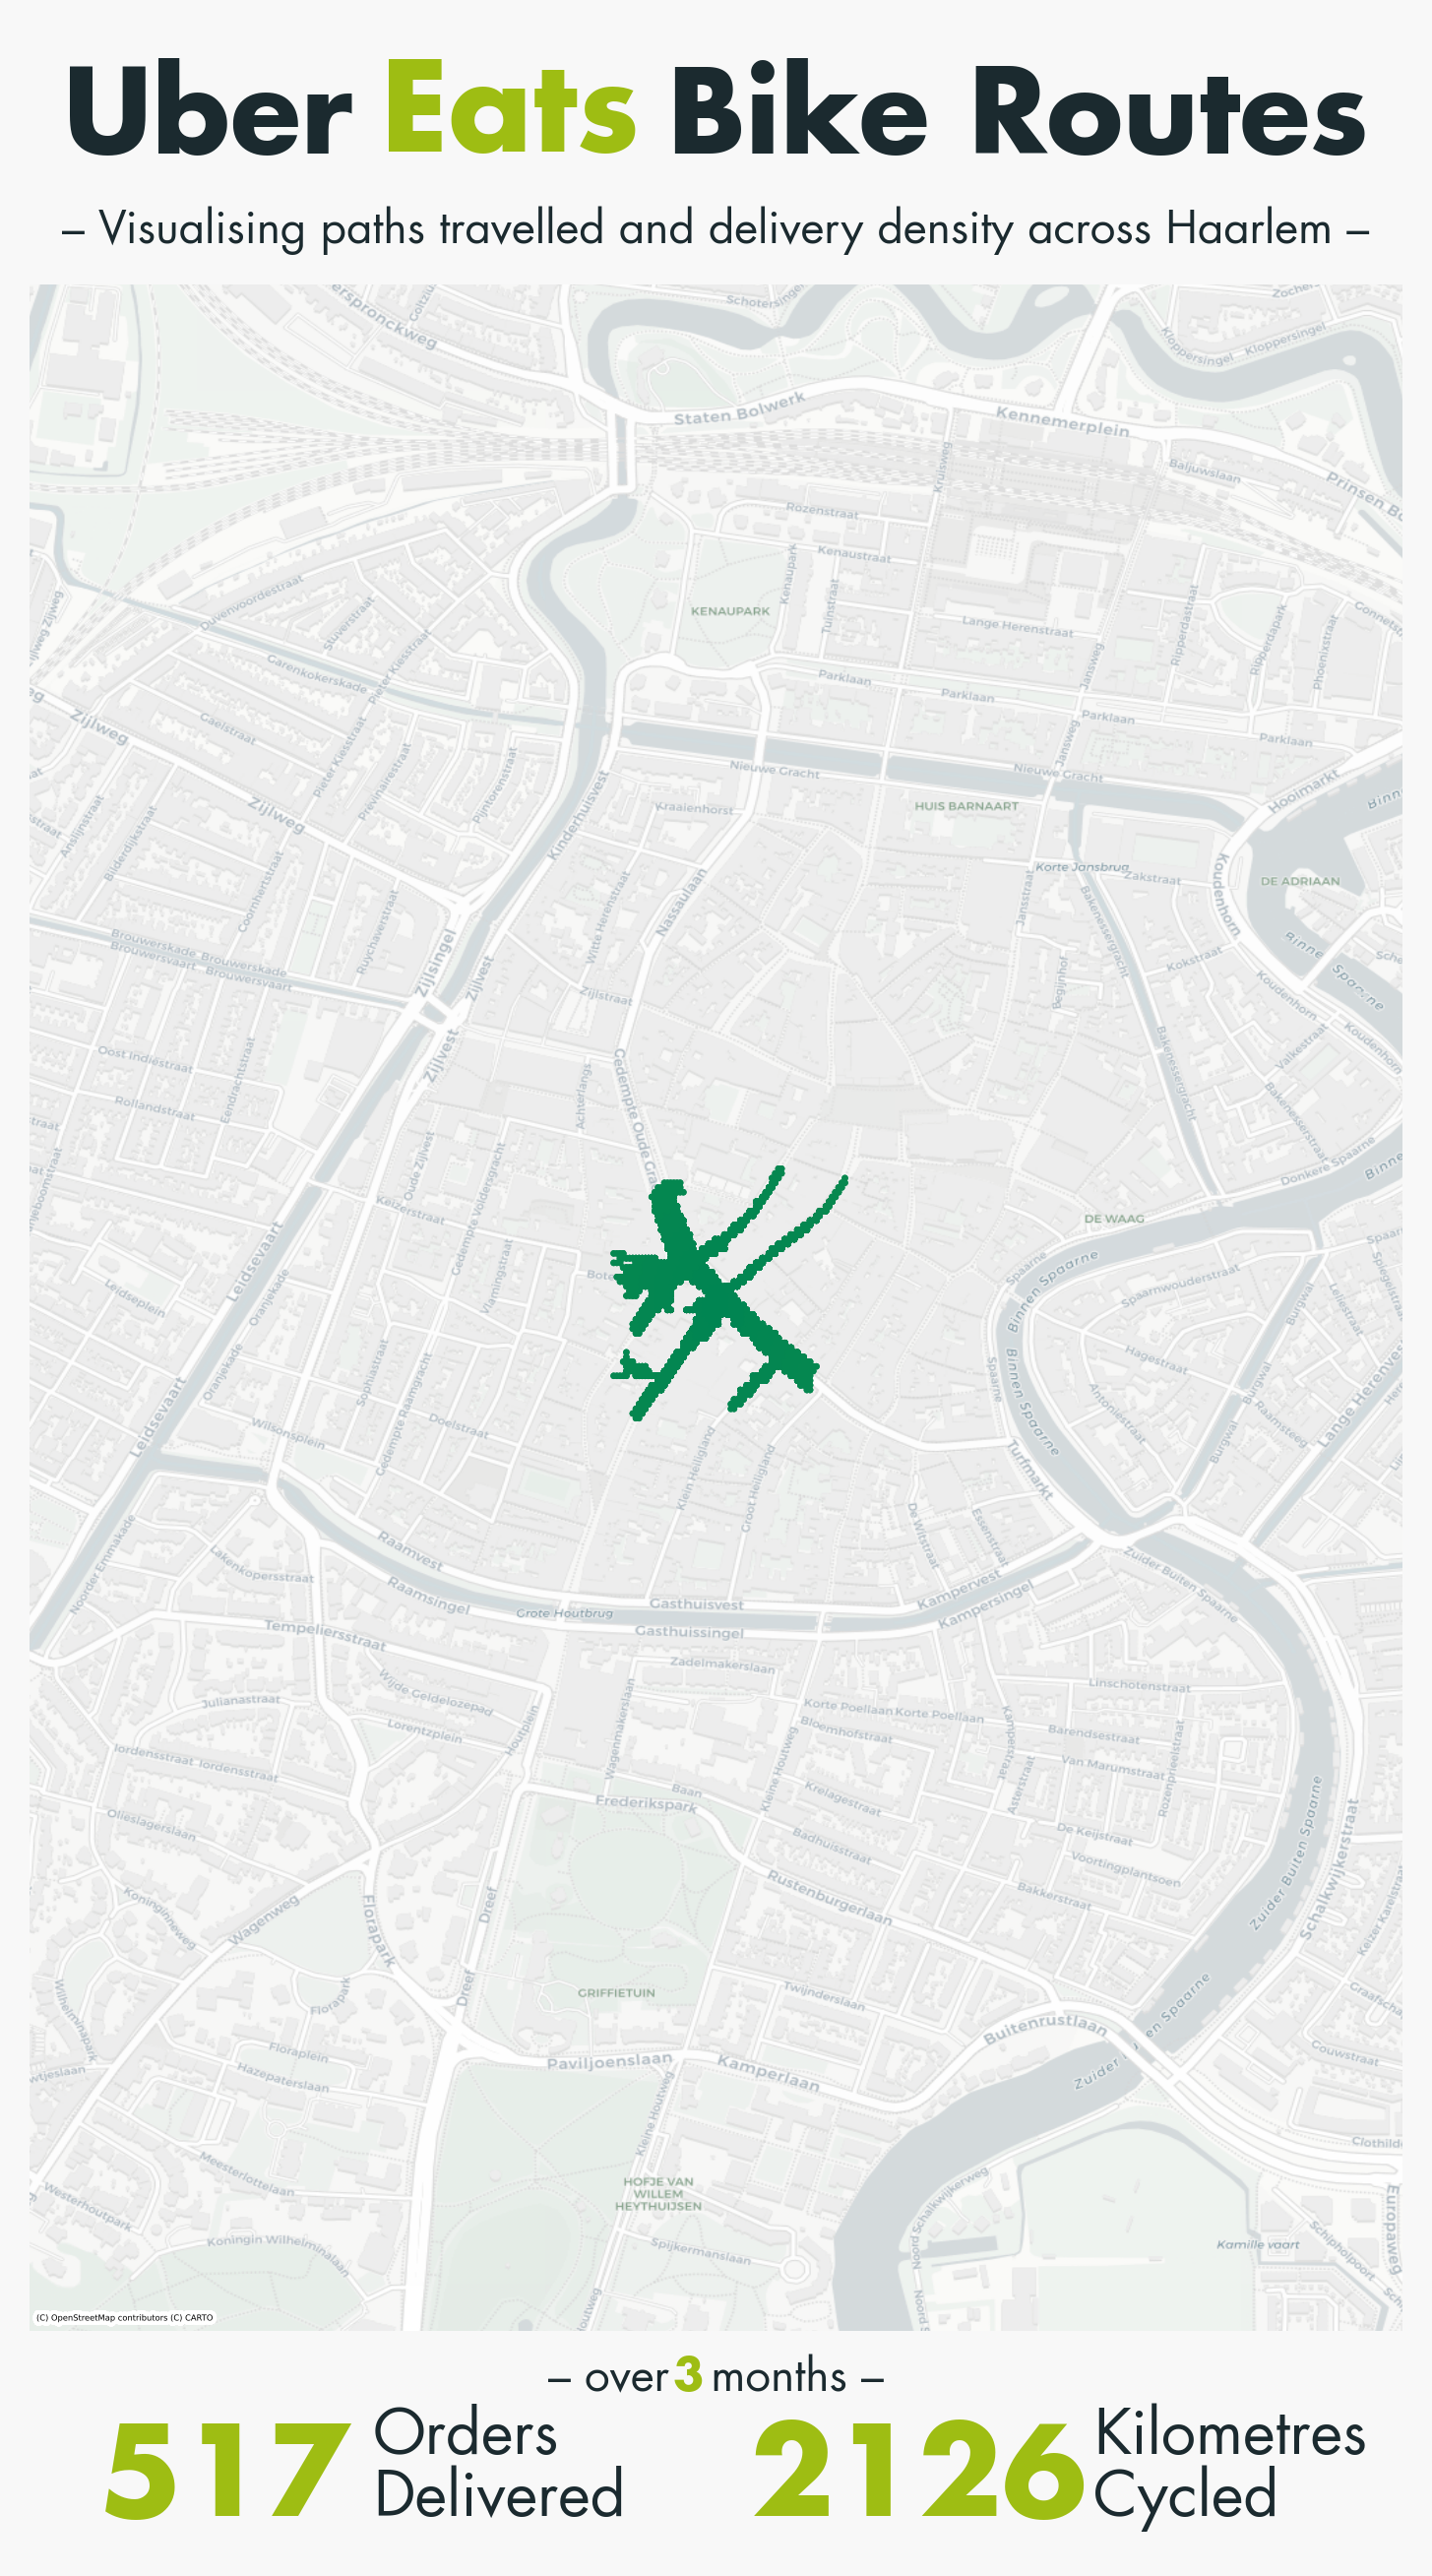

In [154]:
# Animated map visualization –––––

# Set initial frame for artificial points
initial_frame = 175

# Plot –
# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 9), dpi=300)

# Set the background color to white
fig.patch.set_facecolor("#F8F8F8")

# Remove default axis visuals
ax.set_axis_off()

# Title
# Spacing
ax.text(0.5, 1.11, "  ", transform=ax.transAxes)

# Title text
ax.text(0.5, 1.05, "Uber        Bike Routes", transform=ax.transAxes, ha="center", va="bottom",
        fontsize=28, color="#1B2A2F", fontproperties=futura_bold)
ax.text(0.35, 1.05, "Eats", transform=ax.transAxes, ha="center", va="bottom",
        fontsize=30, color="#9ebd13", fontproperties=futura_bold)
ax.text(0.5, 1.015, "– Visualising paths travelled and delivery density across Haarlem –",
        transform=ax.transAxes, ha="center", va="bottom",
        fontsize=11, color="#1B2A2F", fontproperties=futura_book)

# Summary text under the map
ax.text(0.5, -0.035, "– over   months –",
        transform=ax.transAxes, ha="center", va="bottom",
        fontsize=11, color="#1B2A2F", fontproperties=futura_book)
ax.text(0.48, -0.035, "3",
        transform=ax.transAxes, ha="center", va="bottom",
        fontsize=11, color="#9ebd13", fontproperties=futura_bold)

# Orders delivered
ax.text(0.05, -0.09, "517", transform=ax.transAxes, ha="left",
        fontsize=30, color="#9ebd13", fontproperties=futura_bold)
ax.text(0.25, -0.06, "Orders", transform=ax.transAxes, ha="left",
        fontsize=15, color="#1B2A2F", fontproperties=futura_book)
ax.text(0.25, -0.09, "Delivered", transform=ax.transAxes, ha="left",
        fontsize=15, color="#1B2A2F", fontproperties=futura_book)

# Kilometres cycled
ax.text(0.525, -0.09, "2126",
        transform=ax.transAxes, ha="left",
        fontsize=30, color="#9ebd13", fontproperties=futura_bold)
ax.text(0.775, -0.06, "Kilometres", transform=ax.transAxes, ha="left",
        fontsize=15, color="#1B2A2F", fontproperties=futura_book)
ax.text(0.775, -0.09, "Cycled", transform=ax.transAxes, ha="left",
        fontsize=15, color="#1B2A2F", fontproperties=futura_book)

# Spacing
ax.text(0.5, -0.09, "  ", transform=ax.transAxes)


# Loop through frames –
for frame in range(23, frame_number):

    # Artificial points –
    if frame < initial_frame:
        artificial_mask = (artificial_frames <= initial_frame)
    else:
        artificial_mask = (artificial_frames <= frame)

    artificial_subset = artificial_points[artificial_mask]

    # Create GeoDataFrames for artificial points
    gdf_artificial = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(artificial_subset[:,1], artificial_subset[:,0]),
        crs="EPSG:4326"
    ).to_crs(epsg=3857)
    
    # Artificial points (full transparency)
    ax.scatter(x=gdf_artificial.geometry.x,
               y=gdf_artificial.geometry.y,
               s=1000,
               alpha=0)
    
    # Real points –
    plot_data = coordinates[coordinates["frame_by_path"] <= (frame+1)]

    # Create GeoDataFrames for real points
    gdf_route = gpd.GeoDataFrame(
        plot_data,
        geometry=gpd.points_from_xy(plot_data["longitude"], plot_data["latitude"]),
        crs="EPSG:4326"
    ).to_crs(epsg=3857)

    # Real points
    ax.scatter(x=gdf_route.geometry.x,
               y=gdf_route.geometry.y,
               s=10,
               alpha=1,
               c=list(plot_data["gradient_colour"]),
               marker='.',
               linewidths=0)
        
    # Basemap –
    ctx.add_basemap(ax=ax,
                    source=ctx.providers.CartoDB.Positron,
                    crs=gdf_route.crs.to_string(),
                    attribution_size=2)
    
    # Save the figure
    plt.savefig(f"github-pictures/6-tests/final-map-{frame+1}.jpg", dpi=300, bbox_inches="tight")

    # Follow up print
    print(f"Frame {frame+1} created")

# Close the figure
plt.close(fig)